In [2]:
from matplotlib import pyplot as plt
from scitbx.array_family import flex
from scitbx.matrix import col, sqr
from dxtbx.model.experiment_list import ExperimentListFactory
import sys, math, os

# original root = "/reg/d/psdm/cxi/cxis0213/res/brewster/paper_2017/evaluation/r0004_1K_level0_refine"
root = "data/figure6"

In [3]:
# this function returns pairs of angles where the solid angle subtended between any pair is the same as the other pairs
def compute_bins(n):
  A = 2*math.pi # area of unit hemisphere
  theta = 0
  for i in xrange(n):
    new_theta = math.acos(math.cos(theta)-(A/(2*math.pi*n)))
    yield 180*theta/math.pi, 180*new_theta/math.pi
    theta=new_theta

In [4]:
# Show that the solid angles are the same for each bin
for v in compute_bins(10):
  print "theta1, theta2, area between them on unit sphere"
  print v, 2*math.pi*(math.cos(v[0]*math.pi/180)-math.cos(v[1]*math.pi/180))

theta1, theta2, area between them on unit sphere
(0.0, 25.841932763167126) 0.628318530718
theta1, theta2, area between them on unit sphere
(25.841932763167126, 36.86989764584401) 0.628318530718
theta1, theta2, area between them on unit sphere
(36.86989764584401, 45.57299599919429) 0.628318530718
theta1, theta2, area between them on unit sphere
(45.57299599919429, 53.13010235415597) 0.628318530718
theta1, theta2, area between them on unit sphere
(53.13010235415597, 59.99999999999999) 0.628318530718
theta1, theta2, area between them on unit sphere
(59.99999999999999, 66.42182152179817) 0.628318530718
theta1, theta2, area between them on unit sphere
(66.42182152179817, 72.5423968762779) 0.628318530718
theta1, theta2, area between them on unit sphere
(72.5423968762779, 78.4630409671845) 0.628318530718
theta1, theta2, area between them on unit sphere
(78.4630409671845, 84.26082952273322) 0.628318530718
theta1, theta2, area between them on unit sphere
(84.26082952273322, 89.99999999999999) 0

In [5]:
write_pdf=False

axes = ['a','b','c']
all_data = []

for file_id, filename in enumerate(['filtered_experiments.json',
                                    'refined_experiments.json',
                                    'joint/refined_experiments.json']):
  # Load the data
  experiments = ExperimentListFactory.from_json_file(os.path.join(root, filename), check_format=False)
  data = {}
  all_data.append(data)
  for axis in axes:
    data[axis] = {}
    data[axis]['angle'] = flex.double()
    data[axis]['length'] = flex.double()

  # Find basis vector angles for each crystal
  for ext_id, experiment in enumerate(experiments):
    crystal = experiment.crystal
    a, b, c, alpha, beta, gama = crystal.get_unit_cell().parameters()

    amat = sqr(crystal.get_A())
    abasis = amat * col((1, 0, 0))
    bbasis = amat * col((0, 1, 0))
    cbasis = amat * col((0, 0, 1))
    beam = col(experiment.beam.get_s0())

    for axis, basis in zip(axes, [abasis, bbasis, cbasis]):
      length = [a, b, c][['a','b','c'].index(axis)]

      angle = beam.angle(basis, deg=True)
      if angle > 90:
        angle = 90 - (angle - 90)

      data[axis]['angle'].append(angle)
      data[axis]['length'].append(length)


Dataset 0, a axis, n xtals 967, mean length  117.41 +/- 1.01
Dataset 1, a axis, n xtals 967, mean length  115.92 +/- 1.08
Dataset 2, a axis, n xtals 967, mean length  116.05 +/- 0.29
Dataset 0, b axis, n xtals 967, mean length  135.97 +/- 0.70
Dataset 1, b axis, n xtals 967, mean length  134.46 +/- 0.80
Dataset 2, b axis, n xtals 967, mean length  134.61 +/- 0.23
Dataset 0, c axis, n xtals 967, mean length  106.16 +/- 0.62
Dataset 1, c axis, n xtals 967, mean length  104.96 +/- 0.63
Dataset 2, c axis, n xtals 967, mean length  105.07 +/- 0.21
a axis, dataset 0, bin   0.00 -  33.56, mean len  118.05 +/-   1.31
a axis, dataset 0, bin  33.56 -  48.19, mean len  117.26 +/-   1.05
a axis, dataset 0, bin  48.19 -  60.00, mean len  117.03 +/-   0.56
a axis, dataset 0, bin  60.00 -  70.53, mean len  117.00 +/-   0.27
a axis, dataset 0, bin  70.53 -  80.41, mean len  117.05 +/-   0.21
a axis, dataset 0, bin  80.41 -  90.00, mean len  117.09 +/-   0.17
a axis, dataset 1, bin   0.00 -  33.56, mea

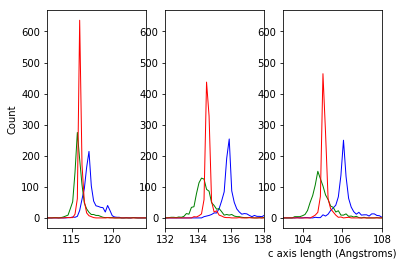

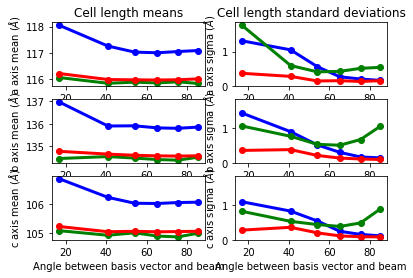

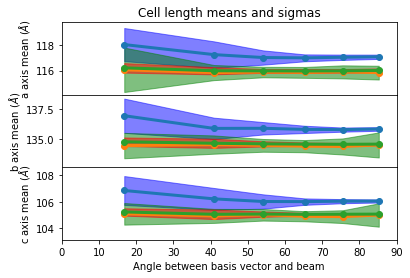

In [7]:
nbins = 30
n_theta_bins = 6
fig = plt.figure()

min_x = [float("inf")] * 3
max_x = [0] * 3
sum_ = [0]*3

min_plot_x = [112, 132, 103]
max_plot_x = [124, 138, 108]

colors = ['blue','green','red']

# Find boundries fo the unit cell histograms
for i, (tmin, tmax) in enumerate(compute_bins(n_theta_bins)):
  for data_id, data in enumerate(all_data):
    for axis_id, axis in enumerate(axes):
      sel = (data[axis]['angle'] >= tmin) & (data[axis]['angle'] < tmax)
      d = data[axis]['length'].select(sel)
      sum_[axis_id] += len(d)

      if flex.min(d) < min_x[axis_id]: min_x[axis_id] = flex.min(d)
      if flex.max(d) > max_x[axis_id]: max_x[axis_id] = flex.max(d)

# Unit cell histogram
fig = plt.figure()
for axis_id, axis in enumerate(axes):
  if axis_id == 0:
    ax0 = ax = plt.subplot(1, len(axes), axis_id + 1)
  else:
    ax = plt.subplot(1, len(axes), axis_id + 1, sharey = ax0)
  if axis_id == 2:
    ax.set_xlabel("%s axis length (Angstroms)"%axis)
  if write_pdf:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
  for data_id, data in enumerate(all_data):
    d = data[axis]['length']
    stats = flex.mean_and_variance(d)
    print "Dataset %d, %s axis, n xtals %d, mean length % 7.2f +/- %.2f"% \
      (data_id, axis, len(d), stats.mean(), stats.unweighted_sample_standard_deviation())
    h = flex.histogram(d, data_min=min_x[axis_id], data_max = max_x[axis_id], n_slots=100)
    plt.plot(h.slot_centers().as_numpy_array(), h.slots().as_numpy_array(), '-', linewidth=1,
             c = colors[data_id])
  ax.set_xlim(min_plot_x[axis_id], max_plot_x[axis_id])

ax0.set_ylabel("Count")
if write_pdf:
  plt.subplots_adjust(wspace=0, hspace=0)

# Binned mean and standard deviation plot
fig = plt.figure()
for axis_id, axis in enumerate(axes):
  plot_num = 2*axis_id + 1
  if axis_id == 0:
    ax0_m = axm = plt.subplot(3, 2, plot_num)
    ax0_s = axs = plt.subplot(3, 2, plot_num+1)
  else:
    axm = plt.subplot(3, 2, plot_num, sharex = ax0_m)
    axs = plt.subplot(3, 2, plot_num+1, sharex = ax0_s, sharey=ax0_s)

  for data_id, data in enumerate(all_data):
    xm = []
    ym = []
    xs = []
    ys = []
    for i, (tmin, tmax) in enumerate(compute_bins(n_theta_bins)):
      sel = (data[axis]['angle'] >= tmin) & (data[axis]['angle'] < tmax)
      d = data[axis]['length'].select(sel)
      stats = flex.mean_and_variance(d)
      xm.append(tmin+((tmax-tmin)/2))
      ym.append(stats.mean())
      xs.append(tmin+((tmax-tmin)/2))
      ys.append(stats.unweighted_sample_standard_deviation())

    axm.plot(xm, ym, 'o-', linewidth=3, c=colors[data_id])
    axs.plot(xs, ys, 'o-', linewidth=3, c=colors[data_id])

  if axis_id == 0:
    axm.set_title("Cell length means")
    axs.set_title("Cell length standard deviations")
  axm.set_ylabel(r"%s axis mean ($\AA$)"%axis)
  axs.set_ylabel(r"%s axis sigma ($\AA$)"%axis)
  if axis_id == 2:
    axm.set_xlabel("Angle between basis vector and beam")
    axs.set_xlabel("Angle between basis vector and beam")

# Cell lengths and sigmas plot
fig = plt.figure()
mean_min = [float("inf")]*3
mean_max = [float("-inf")]*3
max_sigma = 0
for axis_id, axis in enumerate(axes):
  if axis_id == 0:
    ax0 = ax = plt.subplot(3, 1, axis_id+1)
  else:
    ax = plt.subplot(3, 1, axis_id+1, sharex = ax0)

  for data_id, data in enumerate(all_data):
    x = []
    ym = []
    ys = []
    ys1 = []
    ys2 = []
    for i, (tmin, tmax) in enumerate(compute_bins(n_theta_bins)):
      sel = (data[axis]['angle'] >= tmin) & (data[axis]['angle'] < tmax)
      d = data[axis]['length'].select(sel)
      stats = flex.mean_and_variance(d)
      x.append(tmin+((tmax-tmin)/2))
      ym.append(stats.mean())
      ys.append(stats.unweighted_sample_standard_deviation())
      ys1.append(stats.mean() - stats.unweighted_sample_standard_deviation())
      ys2.append(stats.mean() + stats.unweighted_sample_standard_deviation())
        
      print "%s axis, dataset %d, bin % 6.2f - % 6.2f, mean len % 6.2f +/- % 6.2f"%( \
        axis, data_id, tmin, tmax, stats.mean(), stats.unweighted_sample_standard_deviation())

    ax.plot(xm, ym, 'o-', linewidth=3)
    ax.fill_between(x, ys2, ys1, interpolate = True, alpha = 0.50, color = colors[data_id])
    mean_min[axis_id] = min(mean_min[axis_id], min(ym))
    mean_max[axis_id] = max(mean_max[axis_id], max(ym))
    max_sigma = max(max_sigma, max(ys))

  if axis_id == 0:
    ax.set_title("Cell length means and sigmas")
  ax.set_ylabel(r"%s axis mean ($\AA$)"%axis)
  if axis_id != 2:
    ax.xaxis.set_visible(False)
  if axis_id == 2:
    ax.set_xlabel("Angle between basis vector and beam")
plt.subplots_adjust(wspace=0, hspace=0)

for i in xrange(3):
  ax = fig.axes[i]
  ax.set_xlim(0, 90)
  ax.set_ylim(mean_min[i]-max_sigma, mean_max[i]+max_sigma)

if write_pdf:
  from matplotlib.backends.backend_pdf import PdfPages
  pp = PdfPages("basisalignment.pdf")
  for i in plt.get_fignums():
    pp.savefig(plt.figure(i))
  pp.close()
else:
  plt.show()
#plt.figure(6).savefig("basisalignment.svg", format='svg')